# Do a bandstructure calculation from a completed CASTEP run

In [2]:
from __future__ import print_function

In [3]:
%aiida
from ase import Atoms
import numpy as np
StructureData = DataFactory('structure')
ParameterData = DataFactory('parameter')
KpointsData = DataFactory('array.kpoints')

## Query the database
We locate the finished calculations. You can just use `verdi calculation list -p 5 -a` to list all 
calculations in the last five days. 

Here, we demonstrate construction of the queries directly.
The database can be queried using filters and the relations. Effectively, we select a portion of the graph and project out the results. 
More details [here](https://aiida-core.readthedocs.io/en/v0.12.3/querying/querybuilder/usage.html)

In [4]:
q = QueryBuilder()
q.append(Calculation, filters={'label': 'Si SINGLEPOINT',
                               'state': 'FINISHED'},
        project=['id', 'label'])
q.append(ParameterData, 
         output_of=Calculation, project=['attributes.total_energy'])   # Project the energy
q.append(ParameterData, input_of=Calculation,
         edge_filters={"label": 'parameters'},
         project=["attributes.PARAM.basis_precision"])  # Project the input key
q.all()

[[168, u'Si SINGLEPOINT', -337.909591988, u'medium']]

## Create the CastepSpectralCalculation

In [5]:
SpectralCalc = CalculationFactory('castep.spec')

In [21]:
# We select the first calculation
pk = q.first()[0]
sp_calc = load_node(pk)  # Load the calculation Node
spec_calc = SpectralCalc.continue_from(sp_calc, restart_type='continuation')

In [22]:
# The inputs are copied over, note that the 'continuation' keyword is set automaticall
spec_calc.get_castep_input_summary()

{u'CELL': {u'snap_to_symmetry': True, u'symmetry_generate': True},
 u'PARAM': {u'basis_precision': u'medium',
  'continuation': './parent/aiida.check',
  u'fix_occupancy': True,
  u'num_dump_cycles': 0,
  u'opt_strategy': u'memory',
  u'task': 'spectral',
  u'write_formatted_density': True},
 'code': <Code: Remote code 'castep-18.1' on localhost, pk: 157, uuid: 884acb37-9cc5-47b9-8e7b-7fb3f99a26f0>,
 'computer': <Computer: localhost (localhost), pk: 1>,
 'custom_scheduler_commands': '',
 'kpoints': 'Kpoints mesh: 4x4x4 (+0.0,0.0,0.0)',
 'label': u'',
 'pseudos': {u'Si': u'C18'},
 'resources': {},
 'spectral_kpoints': None,
 'structure': {'cell': [[2.6954645, 2.6954645, 0.0],
   [2.6954645, 0.0, 2.6954645],
   [0.0, 2.6954645, 2.6954645]],
  'formula': 'Si2',
  'label': u'Si'},
 'wallclock': None}

## Define the Kpoints used for band structure calculation
Recall:
```
%block bs_kpoint_path 
0.5 0.25 0.75    ! W
0.5 0.5 0.5      ! L
0.0 0.0  0.0     ! Gamma
0.5 0.0 0.5      ! X
0.5 0.25 0.75    ! W
0.375 0.375 0.75 ! K
%endblock bs_kpoint_path 
```
However, rather than putting this directly in the `ParameterData` (which would work as it should), we can define a explicit kpoint path.
Such path may be reused in a layer date for other calculations.

In [23]:
bs_kpoints = KpointsData()

In [24]:
bs_kpoints.set_kpoints_path([('W', (0.5, 0.25, 0.75),
                              'L', (0.5, 0.5, 0.5),),
                              ('L', (0.5, 0.5, 0.5),
                              'Gamma', (0., 0., 0.)),
                              ('Gamma', (0., 0., 0.),
                              'X', (0.5, 0.0, 0.5)),
                             ('X', (0.5, 0.0, 0.5), 
                              'W', (0.5, 0.25, 0.75)),
                              ('W', (0.5, 0.25, 0.75),
                              'K', (0.375, 0.375, 0.75))
                             ],
                            kpoint_distance=0.05
                            )
# The explicity list of kpoints
print('Number of kpoints: ', len(bs_kpoints.get_kpoints()))
bs_kpoints.get_kpoints()

Number of kpoints:  44


array([[0.5       , 0.25      , 0.75      ],
       [0.5       , 0.29166667, 0.70833333],
       [0.5       , 0.33333333, 0.66666667],
       [0.5       , 0.375     , 0.625     ],
       [0.5       , 0.41666667, 0.58333333],
       [0.5       , 0.45833333, 0.54166667],
       [0.5       , 0.5       , 0.5       ],
       [0.46875   , 0.46875   , 0.46875   ],
       [0.4375    , 0.4375    , 0.4375    ],
       [0.40625   , 0.40625   , 0.40625   ],
       [0.375     , 0.375     , 0.375     ],
       [0.34375   , 0.34375   , 0.34375   ],
       [0.3125    , 0.3125    , 0.3125    ],
       [0.28125   , 0.28125   , 0.28125   ],
       [0.25      , 0.25      , 0.25      ],
       [0.21875   , 0.21875   , 0.21875   ],
       [0.1875    , 0.1875    , 0.1875    ],
       [0.15625   , 0.15625   , 0.15625   ],
       [0.125     , 0.125     , 0.125     ],
       [0.09375   , 0.09375   , 0.09375   ],
       [0.0625    , 0.0625    , 0.0625    ],
       [0.03125   , 0.03125   , 0.03125   ],
       [0.

In [25]:
# The labels are also stored
bs_kpoints.get_attrs()

{'array|kpoints': [44, 3],
 'label_numbers': [0, 6, 22, 35, 41, 43],
 'labels': ['W', 'L', 'Gamma', 'X', 'W', 'K']}

In [26]:
# Tell the spectral calculation to use the kpoints list generated
spec_calc.use_spectral_kpoints(bs_kpoints)
spec_calc.update_parameters(spectral_task='bandstructure')  # Oop I forgot to set this earlier
# Resources are not copied over - as it is often different from the inital calculation
spec_calc.set_resources({'num_machines':1, 'tot_num_mpiprocs':2})
spec_calc.set_max_wallclock_seconds(1800)
folder, _ = spec_calc.submit_test()

In [27]:
# Don't forget to label the calculation
spec_calc.label = "Si BS"
spec_calc.description = "A spectral calculation. Reuse the singlepoint calculation previoused generated."

In [28]:
spec_calc.store_all(); spec_calc.submit()

In [30]:
!verdi calculation list -p1 -a

# Last daemon state_updater check: 0h:00m:13s ago (at 20:15:55 on 2019-03-16)
  PK  Creation    State          Sched. state    Computer    Type
----  ----------  -------------  --------------  ----------  -----------
 176  3h ago      FINISHED       DONE            localhost   castep.spec
 184  1m ago      WITHSCHEDULER  QUEUED          localhost   castep.spec
 188  41s ago     FINISHED       DONE            localhost   castep.spec

Total results: 3



## Plot the band structure
The `*bands` file are parsed by `aiida-castep` and the KS eigenvalues can be access directly in python.

In [31]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [32]:
spec_calc.get_state()

u'FINISHED'

In [33]:
bands_node = spec_calc.out.output_bands
bands_data = bands_node.get_bands()
print(bands_data.shape)

(44, 14)


<IPython.core.display.Javascript object>


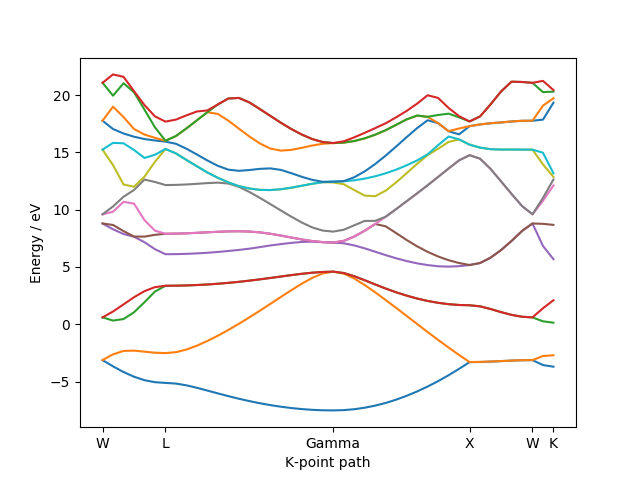

Text(0,0.5,'Energy / eV')

In [36]:
# Plot the band structure
ilbs, lbs = [bs_kpoints.get_attr(s) for s in ('label_numbers', 'labels')]

for eigen in bands_data.T:
    plt.plot(eigen)
plt.xticks(ilbs, lbs)
plt.xlabel("K-point path")
plt.ylabel("Energy / eV")

In [37]:
# Finall we can export the provenanec graph
!verdi graph generate -f png {spec_calc.pk}

Output file is 188.png


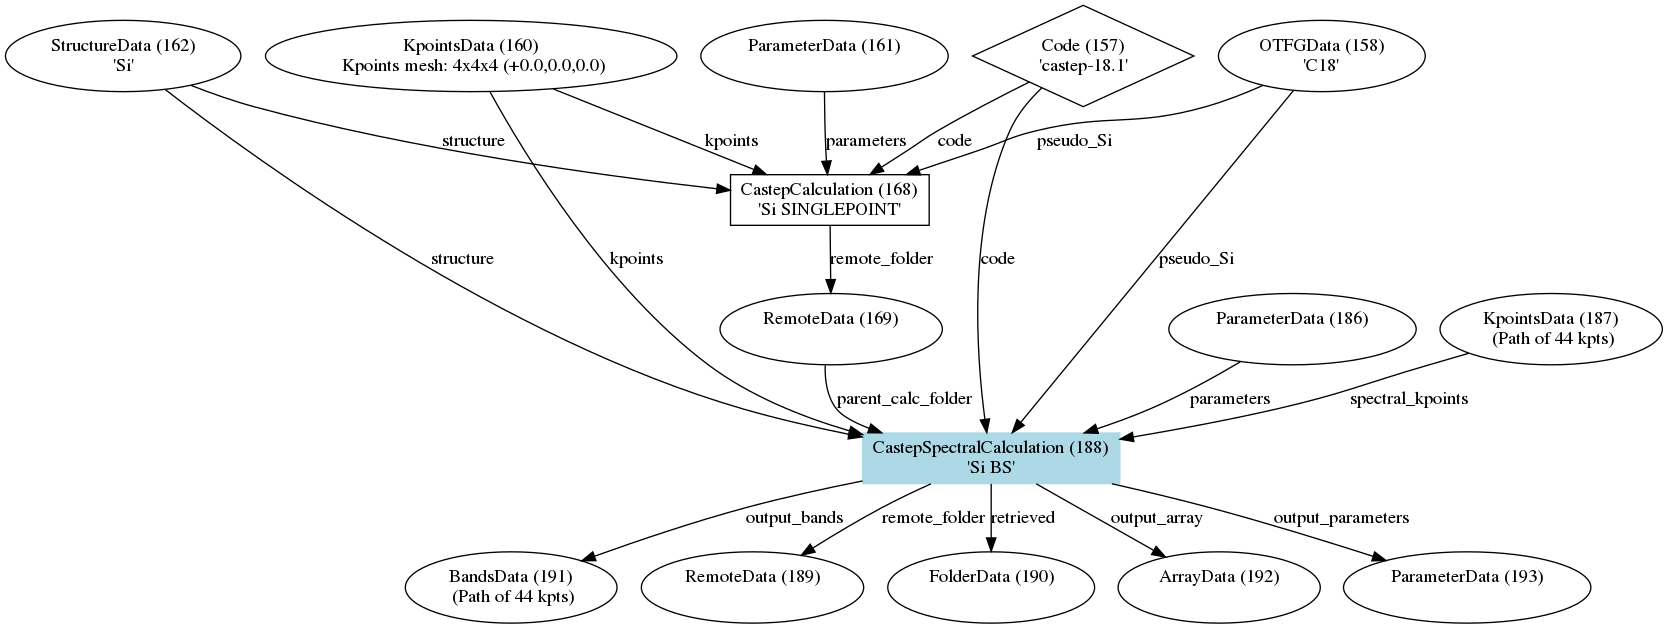

In [38]:
from IPython.display import Image
Image("{}.png".format(spec_calc.pk))